# Imports

In [1]:
%%capture
!pip install fuzzywuzzy
!pip install transformers 
!pip install matplotlib --upgrade 
# !pip install spacy==3.2

In [2]:
import matplotlib
matplotlib.__version__

'3.5.1'

In [3]:
# !python -m spacy download en_core_web_sm

In [4]:
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
tqdm.pandas()

from tqdm import tqdm

In [27]:
import ast
import spacy
import pandas as pd
import numpy as np
from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                             recall_score, confusion_matrix, roc_auc_score)

from bokeh.palettes import Pastel1,cividis, Greens9, RdGy, Oranges9,OrRd9,Reds9,RdYlBu,Blues9, Greys256, Greys
import matplotlib.pyplot as plt
import seaborn as sns#; sns.set_theme()
from fuzzywuzzy import fuzz
import torch  
import os 

nlp = spacy.load('en_core_web_sm')
tokenizer = nlp.tokenizer

In [28]:
spacy.__version__

'2.2.4'

In [7]:
# We need to use gpu to compute mention similarity by BERT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# File Paths

In [8]:
import random
from google.colab import drive
import pickle
drive.mount('/content/drive',force_remount=True)

# Make sure to click "Add shortcut to drive" for the "Coref-for-GPT" folder
gdrive_dir_path = "/content/drive/MyDrive/Coref-for-GPT"


Mounted at /content/drive


In [9]:
root_path = gdrive_dir_path
input_path = f'{root_path}/Results'
results_path = f'{root_path}/Results/Charts_and_plots/final_plots'

In [10]:
MODEL_LABELS = {"multi-sieves": "Multi-pass Sieve",
                "e2e": "E2E",
                "GPT2_gold_mentions": "GPT2",
                "GPT_NEO-125M_gold_mentions":  "GPT-NEO",
                "Streamlining": "Streamlining",
                "GPT2_WSC": "WSC"}

# Utils for Charts

In [11]:
plt.style.use('seaborn-paper') #seaborn-paper

In [12]:
pd.options.display.float_format = "{:,.2f}".format

In [13]:
def create_histogram(ax,pos, neg, title, xlabel, ylabel):
    ax.hist(x=[pos, neg],bins=20,edgecolor='black', 
            label = ["positive", "negative"], color =[RdYlBu[3][2], RdYlBu[3][0]])
    ax.set_yscale('log')
    ax.legend(loc = "upper right")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return ax

In [14]:
def write_table(df, output_file, output_dir):
    path = os.path.join(output_dir,output_file)
    df.to_latex(path, float_format="%.2f")

# def create_bar_plot(df, length, ax, metric, title, xlabel, ylabel, dir_path=results_path):
#     elements = list(df.index)
#     data = df[metric].values
#     colors = Blues9
#     rects =ax.bar(x=elements,   # positions to put the bar to
#            height=data,  # height of each bar
#            width=0.5,   # width of the bar
#            edgecolor='black',   # edgecolor of the bar
#            color=[colors[-int(np.log(l))] for l in length],    # fill color of the bar # Pastel1[5]
#            ecolor='red',
#            capsize=12)
#     ax.tick_params(axis='x',labelsize=10, ) #rotation =90
#     ax.set_xlabel(xlabel)
#     ax.set_ylabel(ylabel)
#     ax.set_title(title)
    
#     # ax.set_ylim(0,1)
#     return ax 

# def plot_multiple_bars(dfs, lengths, nrows, ncols, subtitles, xlabel, ylabel, 
#                        figsize=(20,12),metric="acc", dir_path = results_path):
#     fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize, 
#                             gridspec_kw={'wspace':0.1,'hspace':0.2})
    
#     if nrows > 1 and ncols >1:
#         idx = 0
#         for i in range(nrows):
#             for j in range(ncols):
#                 create_bar_plot(dfs[idx], lengths[idx], axes[i][j], 
#                                 metric, subtitles[idx], xlabel, ylabel)
#                 idx +=1
#     elif nrows > 1:
#         for i in range(nrows):
#             create_bar_plot(dfs[i], lengths[i], axes[i], metric, 
#                             subtitles[i], xlabel, ylabel)
#     elif ncols > 1:
#         for i in range(ncols):
#             create_bar_plot(dfs[i], lengths[i], axes[i], 
#                             metric, subtitles[i], xlabel, ylabel)
#     else:
#         create_bar_plot(dfs[0], lengths[0], axes, metric, subtitles[0], xlabel, ylabel)

#     fig.savefig(f"{dir_path}{subtitles[0]}.png", dpi = 100,bbox_inches = 'tight')
#     print(f"Image saved to {dir_path}{subtitles[0]}.png")
#     return fig

def create_line_plot(dfs, labels, metric, title, xlabel, ylabel, figsize, dir_path = results_path):
    fig,ax = plt.subplots(figsize = figsize)
    # colors = grey(10)
    # 'Blues','Oranges','Greens', 'Purples',
    # labels = ["GPT-2", "GPT-Neo", "multi-sieves", "e2e"]
    for i,df in enumerate(dfs):
        ax.plot(df.index, df[metric].values, label = labels[i],
                marker='o',markersize=4, )
        
    ax.set_xlabel(xlabel.capitalize())
    ax.set_ylabel(ylabel.capitalize())
    ax.set_title(title)
    ax.legend(loc = "upper left")
    fig.savefig(f"{dir_path}/{title}_{metric}_line.png", dpi = 100,bbox_inches = 'tight')
    return fig

In [15]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)
    
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}", lengths_map=None,
                     textcolors=("black", "white"), #Greys[9], #
                     threshold=None, 
                     **textkw):
    print(textcolors)
    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            c = textcolors[int(im.norm(data[i, j]) > threshold)]
            if data[i, j] <= 1:
                text = im.axes.text(j, i, valfmt(lengths_map[i][j], None), **kw)
            else:
                text = "-"
            texts.append(text)

    return texts

In [61]:
def create_stacked_bar_plot(dfs, lengths, labels, 
                            figsize, metric, title, xlabel, ylabel, dir_path=results_path):
    fig,ax= plt.subplots(nrows=1,ncols=1,figsize=figsize, 
                            gridspec_kw={'wspace':0.1,'hspace':0.2})


    # "GPT-2", "GPT-Neo", "multi-sieves", "e2e"
    # Blues, Oranges, Greens, Reds
    base_cmaps = ['Blues','Oranges','Greens', 'Purples','Reds' ] #'Greys','Reds',
    N = 10
    colors = [plt.get_cmap(name)(np.linspace(0.2,0.8,N)) for name in base_cmaps]
    # print(len(colors), len(colors[0]))
    # print(colors)
    for i in range(len(dfs)):
        df = dfs[i]
        length = lengths[i]
        # colors = colors_list[i]
        label = labels[i]
        # print(df.index)
        elements = np.arange(len(df))-0.2 + 0.1*i#np.array(df.index)#
        data = df[metric].values
        # ax.set_ylim(0,0.5)
        rects =ax.bar(x=elements,   # positions to put the bar to
                    height=data,  # height of each bar
                    width=0.1,   # width of the bar
                    edgecolor='white',   # edgecolor of the bar,
                    # edgewidth
                    color=[colors[i][-int(np.log(l))] for l in length],    # fill color of the bar # Pastel1[5]
                    ecolor='red',
                    capsize=10,
                    label=label)
        ax.set_xticklabels(df.index)
        
        # ax.bar_label(rects, labels=['%.3f' % l for l in data], fontsize=8) #labels=['%.0f' % l for l in length]
    
    ax.tick_params(axis='x',labelsize=10, ) #rotation =90
    ax.set_xticks(elements-0.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    
    fig.savefig(f"{dir_path}/{title}.png", dpi = 200,bbox_inches = 'tight')
    print(f"Image saved to {dir_path}/{title}.png")

    return ax 

# Utils for Data Processing

## Process prediction results

In [17]:
def get_prob(pred, count):
    if count == 0:
        # If the model didn't produce any yes or no, it means the model is totally uncertain about the result
        return np.nan
    else:
        return pred/count
        
def process_prediction_results(model_name, n_shot=4, prefix_type="ecb", threshold=0.5, reverse = False):
    dir_name = MODEL_LABELS[model_name]
    if model_name == "GPT2_WSC":
        path = os.path.join(input_path,f"{dir_name}/{model_name}_{n_shot}-shots_5-repeats.csv")
    else:
        path = os.path.join(input_path,f"{dir_name}/{model_name}_{n_shot}-shots_{prefix_type}_prefix_5-repeats.csv")

    df = pd.read_csv(path)
    df = df[df.label != 'label'] # get rid of header rows
    df.label = df.label.apply(lambda x:int(float(x)))

    # Adds in the predicted probability for each of the prompts, so how many yes (left number) from total (right number)
    for i in range(1,6):
        df['pred_prob {}'.format(i)] = df['Prompt {}'.format(i)].apply(lambda x:get_prob(ast.literal_eval(x)[0], ast.literal_eval(x)[1]))
        if reverse:
            df['pred_prob {}'.format(i)] = 1-df['pred_prob {}'.format(i)]

    for i in range(1,6):
        # Adds in boolean yes or no
        df["pred {}".format(i)] = df["pred_prob {}".format(i)].apply(lambda x: int(x >= threshold))

    majority_columns = [f"pred {i}" for i in range(1,6)]
    df["pred majority"] = df[majority_columns].mode(axis=1)[0]
   
    avg_columns = [f"pred_prob {i}" for i in range(1,6)]
    df["pred mean"] = df[avg_columns].mean(axis=1)
    
    df = df.drop(columns = ['text','mention pair'])
    return df

In [18]:
def process_prediction_results_nonGPT(model_name, threshold=0.5):
    if model_name == "multi-sieves":
        path = os.path.join(input_path,"Multi-pass-Sieve/pairwise_result.csv")
        df = pd.read_csv(path)
        df.columns = ["pair","label","pred", "mention pair","sent idx","sentence","sent filter","doc name"]
    elif model_name == "e2e":
        path = os.path.join(input_path,"e2e-coref/pairwise_result.csv")
        df = pd.read_csv(path, header = None, )
        df.columns = ["pair","label","mention pair", "sent idx","sentence", "sent filter","pred", "doc name"]
    
    elif model_name == "Streamlining":
        path = os.path.join(input_path,"Streamlining/pairs_with_mentions.csv")    
        df = pd.read_csv(path)
    
    else:
        raise Exception("Invalid model name. Options are 'multi-sieves' or 'e2e'.")

    df = df[df.label != 'label'] # get rid of header rows
    df.label = df.label.apply(lambda x:int(float(x)))

    if model_name == "Streamlining":
        df['pred mean'] = 1 * (df['pred_proba'] >= threshold)
        df['pred majority'] = 1 * (df['pred_proba'] >= threshold)#df['pred_proba']
    else:
        # to make it easier for us to use later scoring functions
        df.pred = df.pred.apply(lambda x:int(float(x)))
        df["pred mean"] = df.pred
        df["pred majority"] = df.pred
    
    # df = df.drop(columns = ['mention pair',"sent idx","sent filter"])
    return df[['label', 'pred mean', 'pred majority']]

## Process mention information (i.e., entity types, mention similarity)

In [19]:
from sklearn.metrics.pairwise import cosine_similarity


In [20]:
# !pip install spacy==2.2.1
# !pip install transformers==2.11.0
# !pip install spacy-transformers[cuda100]==0.6.2
# !python -m spacy download en_trf_bertbaseuncased_lg

# is_using_gpu = spacy.prefer_gpu()
# if is_using_gpu:
#     torch.set_default_tensor_type("torch.cuda.FloatTensor")

# trf = spacy.load('en_trf_bertbaseuncased_lg')

In [21]:
# def find_candidate_tokens(mention, sentence, start_idx = 0):
#     candidate_tokens = []
#     index = []
#     for i, token in enumerate(sentence):
#         if i < start_idx:
#             continue
#         len_matched = len(candidate_tokens)
#         if (len_matched ==0) and (token.text == mention[0].text):
#             candidate_tokens.append(token)
#             index.append(i+start_idx)
#         elif (len_matched !=0) and (token.text == mention[len_matched].text):
#             candidate_tokens.append(token)
#             index.append(i+start_idx)
#         else:
#             candidate_tokens = []
#             index = []
    
#         if len(candidate_tokens) == len(mention):
#             break
#     # print("index:", index)
#     return index


In [22]:
# def contextual_mention_similarity(m1,m2,sents, nlp=trf, tokenizer=trf.tokenizer):
#     if isinstance(sents, str):
#         s = sents.lower()
#     else:
#         if sents[0] == sents[1]:
#             same_sent = True
#             s = sents[0].lower()
#         else:
#             same_sent = False
#             s = " ".join(sents).lower()

#     s = nlp(s)
#     m1, m2 = tokenizer(m1), tokenizer(m2)
#     index1 = find_candidate_tokens(m1, s, start_idx = 0)
#     if len(index1) == 0:
#         print("didn't match: ", m1, s)
#         return np.nan
#     index2 = find_candidate_tokens(m2, s, start_idx = index1[-1]+1)
#     if len(index2) == 0:
#         print("didn't match: ", m2, s)
#         return np.nan
#     # print(s[index1[0]:index1[-1]+1], s[index2[0]:index2[-1]+1])
#     return s[index1[0]:index1[-1]+1].similarity(s[index2[0]:index2[-1]+1]) 

In [23]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = datapath(os.path.join(root_path,"Data","Glove","glove.6B.100d.txt"))
word2vec_glove_file = get_tmpfile("glove.6B.100d.word2vec.txt")
glove2word2vec(glove_file, word2vec_glove_file)
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_glove_file)


In [56]:
# pronoun list (personal, reflective, possesive pronouns): https://gist.github.com/mohataher/837a1ed91aab7ab6c8321a2bae18dc3e
PRONOUNS = set(pd.read_csv("/content/drive/MyDrive/Coref-for-GPT/Evaluation/english-pronouns-list").reset_index()["index"].apply(lambda x: x[3:-1]))
PRONOUNS = PRONOUNS - set([''])
len(PRONOUNS)

def extract_mention_and_pos(text, mention_text):
    mention_token_to_match = tokenizer(mention_text)
    all_tokens = nlp(text)

    candidate_tokens = []
    for token in all_tokens:
        len_matched = len(candidate_tokens)
        if (len_matched ==0) and (token.text == mention_token_to_match[0].text):
            candidate_tokens.append(token)
        elif (len_matched !=0) and (token.text == mention_token_to_match[len_matched].text):
            candidate_tokens.append(token)
        else:
            candidate_tokens = []
    
        if len(candidate_tokens) == len(mention_token_to_match):
            break

    all_pos = []
    all_entity_types = []
    for token in candidate_tokens:
        all_entity_types.append(token.ent_type_)
        all_pos.append(token.pos_)
        if token.text in PRONOUNS:
            all_pos.append("PRON")

    return all_pos, all_entity_types

def mention_pair_to_tags_nonGPT(row):
    m1, m2 = row['mention 1'], row["mention 2"]
    if "text" in row:
        texts = ast.literal_eval(row['text'])
    else:
        texts = ast.literal_eval(row['sentence_text'])
    result = {}
    for i,m in enumerate([m1, m2]):
        col_name = "m%s "%(i+1)
        if isinstance(m, str):
            pos, entity = extract_mention_and_pos(texts[i], m)
        else:
            pos, entity = extract_mention_and_pos(texts[i], " ".join(m["tokens"]))
        result[col_name + "pos"] = pos
        result[col_name + "entity types"] = entity

    if not result:
        print("No value for %s"%(row)) 
    # print(result)
    return result

In [54]:
def compute_similarity(a,b):
    score = cosine_similarity(a, b)[0][0]
    score = max(score, 0)
    return score*100

In [25]:
def embedding_mention_similarity(m1,m2, word2vec=word2vec_model):
    m1_tokens = m1.split()
    m2_tokens = m2.split()
    m1_emb = []
    for t in m1_tokens:
        if t in word2vec:
            m1_emb.append(word2vec[t])

    if not m1_emb:
        return np.nan
    m1_emb = np.mean(np.array(m1_emb), axis = 0)

    m2_emb = []
    for t in m2_tokens:
        if t in word2vec:
            m2_emb.append(word2vec[t])
            
    if not m2_emb:
        return np.nan
    m2_emb = np.mean(np.array(m2_emb), axis = 0)
    
    return compute_similarity(m1_emb.reshape(1,-1), m2_emb.reshape(1,-1))

In [30]:
def extract_mention_pair_nonGPT(x):
    m1,m2 = ast.literal_eval(x.replace('\n', ','))
    mentions = []
    for i,m in enumerate([m1, m2]):
        mentions.append(" ".join(m["tokens"]))
    # print("mentions:", mentions)
    return ";".join(mentions)

In [32]:
def process_mention_info_nonGPT(model_name,  parse_entity_type= True, mention_similarity_type=None):
    if model_name == "multi-sieves":
        path = os.path.join(input_path,"Multi-pass-Sieve/pairwise_result.csv")
        df = pd.read_csv(path,header = None,)
        df.columns = ["pair","label","pred", "mention pair","sent idx","text","sent filter","doc name"]
        df["parsed mention pair"] = df["mention pair"].apply(lambda x: extract_mention_pair_nonGPT(x))
        df = df.join(df['parsed mention pair'].str.split(';', 1, expand=True).rename(columns={0:'mention 1', 1:'mention 2'}))
        
    elif model_name == "e2e":
        path = os.path.join(input_path, "e2e-coref/pairwise_result.csv")
        df = pd.read_csv(path, header = None, )
        df.columns = ["pair","label","mention pair", "sent idx", "text", "sent filter","pred", "doc name"]
        df["parsed mention pair"] = df["mention pair"].apply(lambda x: extract_mention_pair_nonGPT(x))
        df = df.join(df['parsed mention pair'].str.split(';', 1, expand=True).rename(columns={0:'mention 1', 1:'mention 2'}))

    elif model_name == "Streamlining":
        path = os.path.join(input_path, "Streamlining/pairs_with_mentions.csv")
        df = pd.read_csv(path)
        df = df.rename(columns={'mention_1':'mention 1', 'mention_2':'mention 2'})

    else:
        raise Exception("Invalid model name. Options are 'multi-sieves' or 'e2e'.")
    
    df = df[df.label != 'label'] # get rid of header rows
    df.label = df.label.apply(lambda x:int(float(x)))

    if parse_entity_type:
        parsed_mention_info = df.progress_apply(lambda row: mention_pair_to_tags_nonGPT(row), axis=1)
        parsed_mention_info_df = pd.DataFrame(parsed_mention_info.tolist())
        df = pd.concat([df, parsed_mention_info_df], axis=1,)
    
    if mention_similarity_type == "fuzzy":
        df['mention similarity'] = df.progress_apply(lambda x: fuzz.ratio(x['mention 1'].lower(), x['mention 2'].lower()), axis =1)
    elif mention_similarity_type == "word2vec":
        df['mention similarity'] = df.progress_apply(lambda x: embedding_mention_similarity(x['mention 1'].lower(), x['mention 2'].lower()), axis =1)
    # elif mention_similarity_type == "bert":
    #     df['mention similarity'] = df.progress_apply(lambda x: contextual_mention_similarity(x['mention 1'].lower(), x['mention 2'].lower(), x["sentence"]), axis =1)
    else:
        pass
    return df


In [33]:
def extract_mention_pair_GPT(x):
    m1,m2 = ast.literal_eval(x.replace('\n', ','))
    mentions = []
    for i,m in enumerate([m1, m2]):
        mentions.append(m["mention"])
    return ";".join(mentions)

def mention_pair_to_tags_GPT(row):
    m1, m2 = row['mention 1'], row["mention 2"]
    text = row['text']
    result = {}
    for i,m in enumerate([m1, m2]):
        col_name = "m%s "%(i+1)
        pos, entity = extract_mention_and_pos(text, m["mention"])
        result[col_name + "pos"] = pos
        result[col_name + "entity types"] = entity

    if not result:
        print("No value for %s"%(text, x)) 
    return result

def process_mention_info(model_name, n_shot, prefix_type, parse_entity_type=True, mention_similarity_type=None, model_labels = MODEL_LABELS):
    dir_name = MODEL_LABELS[model_name]
    path = os.path.join(input_path, dir_name,f"{model_name}_{n_shot}-shots_{prefix_type}_prefix_5-repeats.csv")
    print("path:",path)
    df = pd.read_csv(path)
    df = df[df.label != 'label'] # get rid of header rows
    df.label = df.label.apply(lambda x:int(float(x)))
    df["parsed mention pair"] = df["mention pair"].apply(lambda x: extract_mention_pair_GPT(x))
    df = df.join(df['parsed mention pair'].str.split(';', 1, expand=True).rename(columns={0:'mention 1', 1:'mention 2'}))

    if parse_entity_type:
        parsed_mention_info = df.progress_apply(lambda row: mention_pair_to_tags_GPT(row), axis=1)
        parsed_mention_info_df = pd.DataFrame(parsed_mention_info.tolist())
    
        full_columns = list(df.columns) + list(parsed_mention_info_df.columns)
        df = df.reset_index(drop=True) 
        parsed_mention_info_df = parsed_mention_info_df.reset_index(drop=True) 
        df = pd.concat([df, parsed_mention_info_df], axis=1, )

    if mention_similarity_type == "fuzzy":
        df['mention similarity'] = df.progress_apply(lambda x: fuzz.ratio(x['mention 1'].lower(), x['mention 2'].lower()), axis =1)
    elif mention_similarity_type == "word2vec":
        df['mention similarity'] = df.progress_apply(lambda x: embedding_mention_similarity(x['mention 1'].lower(), x['mention 2'].lower()), axis =1)
    # elif mention_similarity_type == "bert":
    #     df['mention similarity'] = df.progress_apply(lambda x: contextual_mention_similarity(x['mention 1'].lower(), x['mention 2'].lower(), x["text"]), axis =1)
    else:
        pass
    return df
    


In [34]:
# def flatten_list(l):
#     return [item for sublist in l for item in sublist]

# Define Metrics

In [35]:
METRICS = {"acc": accuracy_score,
           "precision": precision_score,
           "recall": recall_score,
           "f1": f1_score,
           "auc": roc_auc_score}

def get_metrics_scores(df, metrics=METRICS, aggregate_type = "majority", threshold = 0.5,):
    true = df["label"].values 
    if aggregate_type == "majority":
        pred = df["pred majority"].values
    elif aggregate_type == "mean":
        pred = (df["pred mean"] >= threshold).astype(int).values
    else:
        raise Exception("Invalid aggregate type.")
    scores = {}
    for name, scorer in metrics.items():
        scores[name] = scorer(true, pred)
    
    return scores

# General Evaluation

## Performance Comparison 

In [36]:
def get_score_for_models(model_name, aggregate_type="mean"):
    if model_name in ["multi-sieves", "e2e", 'Streamlining']:
        df = process_prediction_results_nonGPT(model_name)
    elif model_name in ["GPT2_gold_mentions", "GPT_NEO-125M_gold_mentions","GPT2_WSC"]:
        df = process_prediction_results(model_name, 4, "ecb")
    # elif model_name in ['Streamlining']:
    #     df = process_prediction_results_streamlining()
    else:
        raise Exception("Invalid model name.")
    scores = get_metrics_scores(df)
    return scores

In [37]:
models = ["multi-sieves","e2e","Streamlining","GPT2_gold_mentions",  "GPT_NEO-125M_gold_mentions", "GPT2_WSC"] #"GPT_NEO-125M_gold_mentions",
models_performance = {}
for model in models:
    scores = get_score_for_models(model, aggregate_type="mean")
    models_performance[model] = scores
models_performance = pd.DataFrame(models_performance)
models_performance.columns = ["Multi-pass Sieve","E2E","Streamlining","GPT2", "GPT-NEO","GPT2_WSC"] #"GPT-NEO", 
models_performance = models_performance.T
models_performance

,acc,precision,recall,f1,auc
Multi-pass Sieve,0.93,0.39,0.20,0.27,0.59
E2E,0.95,0.62,0.46,0.53,0.72
Streamlining,0.94,0.87,0.19,0.31,0.59
GPT2,0.50,0.08,0.53,0.14,0.51
GPT-NEO,0.38,0.08,0.68,0.15,0.52
GPT2_WSC,0.37,0.37,1.00,0.54,0.50


In [38]:
write_table(models_performance, "models_performance.tex", results_path)

## Distributions of predicted values

In [39]:
def get_pred_distribution(model_name, aggregate_type="mean"):
    if model_name in ["multi-sieves", "e2e", 'Streamlining']:
        df = process_prediction_results_nonGPT(model_name)
    elif model_name in ["GPT2_gold_mentions", "GPT_NEO-125M_gold_mentions", "GPT2_WSC"]:
        df = process_prediction_results(model_name)
    else:
        raise Exception("Invalid model name")

    if aggregate_type == "mean":
        df["pred"] = df["pred mean"]
    elif aggregate_type == "majority":
        df["pred"] = df["pred mean"]
    else:
        raise Exception("Invalid aggregate_type.")
    return   df

In [40]:
models = ["multi-sieves", "e2e", "Streamlining", 
          "GPT2_gold_mentions", "GPT_NEO-125M_gold_mentions", ] #"GPT2_WSC",

all_predictions = []
for model in models:
    df = get_pred_distribution(model, aggregate_type="mean")
    df["model"] = model
    all_predictions.append(df)

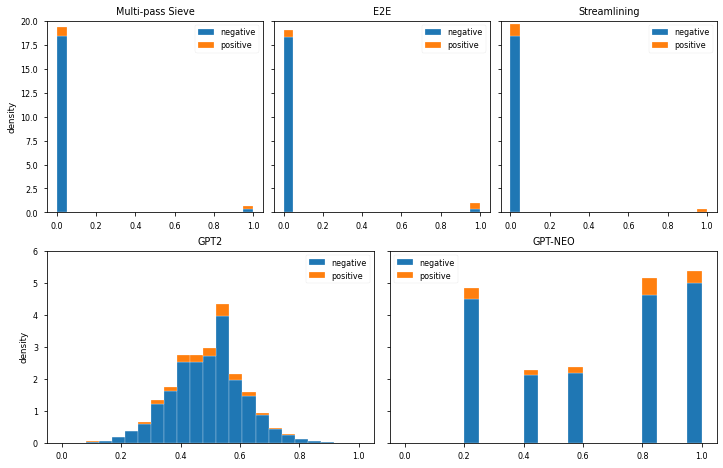

In [41]:
fig = plt.figure(figsize=(12,12))

ax1 = plt.subplot2grid(shape=(3, 3), loc=(0, 0))
ax2 = plt.subplot2grid(shape=(3, 3), loc=(0, 1), sharex=ax1)
ax3 = plt.subplot2grid(shape=(3, 3), loc=(0, 2), sharex=ax1)
ax4 = plt.subplot2grid((3, 2), (1, 0))
ax5 = plt.subplot2grid((3, 2), (1, 1), sharex=ax4)
axes = [ax1, ax2, ax3, ax4, ax5]

for i in range(len(all_predictions)):
    df = all_predictions[i]
    axes[i].hist([df[df["label"]==0]['pred'], df[df["label"]==1]['pred']], 
         bins=20, label=["negative","positive"], density=True, 
        stacked=True,edgecolor='white',) #["#80CED7", "#DC143C"] color = ["#80CED7", "#DC143C"]
    if i in [0, 3]:
        axes[i].set_ylabel("density")
    else:
        axes[i].set_yticklabels([])
    if i < 3:
        axes[i].set_ylim(0,20)
    else:
        axes[i].set_ylim(0,6)
    axes[i].set_title(MODEL_LABELS[models[i]])
    
    axes[i].legend()
plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=None)
fig.savefig(os.path.join(results_path, "distribution_plot.png"), dpi = 100,bbox_inches = 'tight')

## Error Analysis

### comparison on different shots 

In [42]:
def comparison_n_shots(n_shots, model_name, prefix_type, metrics=METRICS, aggregate_type="mean", threshold=0.49):
    rows = {}
    dfs = []
    lengths = []
    for n in n_shots:
        df = process_prediction_results(model_name, n, prefix_type,threshold)
        dfs.append(df)
        lengths.append(len(df))
        scores = get_metrics_scores(df, metrics, aggregate_type, threshold)
        rows[f"{n}-shots"] = scores
    rows = pd.DataFrame(rows).T
    return rows, dfs, lengths

In [43]:
# We should use "mean" for 0-shot as there are lots of invalid predictions, i.e., not "yes" or "no"
example_type = "ecb"
model = "GPT2_gold_mentions" #"GPT_NEO-125M_gold_mentions" 
res, dfs,lengths = comparison_n_shots([0, 2, 4,10], model, example_type,)
display(res)
write_table(res, f"comparison_n_shots_{example_type}_{model}.tex", results_path)

,acc,precision,recall,f1,auc
0-shots,0.57,0.07,0.39,0.13,0.49
2-shots,0.39,0.08,0.64,0.14,0.50
4-shots,0.51,0.08,0.51,0.14,0.51
10-shots,0.18,0.08,0.90,0.15,0.51


### comparison on different example types

In [44]:
def comparison_example_types(example_types, model_name, n_shot, metrics=METRICS, aggregate_type="mean", threshold=0.5001):
    rows = {}
    dfs = []
    lengths = []
    for ex_type in example_types:
        df = process_prediction_results(model_name, n_shot, ex_type,threshold,)
        dfs.append(df)
        lengths.append(len(df))
        scores = get_metrics_scores(df, metrics, aggregate_type, threshold)
        rows[f"{ex_type}"] = scores
    rows = pd.DataFrame(rows).T
    return rows, dfs, lengths

In [45]:
example_types = ["simple", "superglue", "ecb"]
res, dfs, lengths = comparison_example_types(example_types, "GPT2_gold_mentions", 4)
write_table(res, "comparison_example_types.tex", results_path)
display(res)

,acc,precision,recall,f1,auc
simple,0.61,0.08,0.36,0.13,0.50
superglue,0.08,0.08,1.00,0.15,0.50
ecb,0.54,0.08,0.48,0.14,0.51


In [58]:
## Prepare data

# models = ["GPT2_gold_mentions", "GPT_NEO-125M_gold_mentions","multi-sieves", "Streamlining", "e2e"] # 
# for model in models:
#     if model in ["GPT2_gold_mentions", "GPT_NEO-125M_gold_mentions"]:
#         mention_info = process_mention_info(model, 4, "ecb",)
#         pred_info = process_prediction_results(model, 4, "ecb",).reset_index(drop=True)

#         df = pd.concat([pred_info, mention_info.drop(columns=['Prompt 1', 'Prompt 2', 'Prompt 3', 'Prompt 4', 'Prompt 5', 
#                                                       'doc_name','sent_idx', 'mention pair', 'label'])], axis=1)
#     else:
#         mention_info = process_mention_info_nonGPT(model)
#         pred_info = process_prediction_results_nonGPT(model).reset_index(drop=True)
#         df = pd.concat([pred_info, mention_info], axis=1)

    
#     target_poses = ['PRON','PROPN']
#     for pos in target_poses:
#         for m in ["m1", "m2"]:
#             df[m+"_has_"+pos] = df[m+" pos"].apply(lambda x: pos in x if isinstance(x, list) else False).astype(int)

#     for m in ["m1", "m2"]:
#         df[m+"_is_PRON"] = df[m+"_has_PRON"].copy()
#         df[m+"_is_PROPN"] = ((df[m+"_has_PROPN"]-df[m+"_has_PRON"]) > 0).astype(int)
#         df[m+"_is_NOM"] = ((1-df[m+"_is_PROPN"]-df[m+"_is_PRON"]) > 0).astype(int)
#     print(df.shape)
#     path = os.path.join(results_path,f"{model}_pos_results.csv")
#     df.to_csv(path, index = False)

  0%|          | 0/4263 [00:00<?, ?it/s]

(4263, 32)


### performance across different Part-of-Speech tags 

In [59]:
def get_pos_scores(df):
    noun_phrase_types = ["PRON", "PROPN","NOM"]
    lengths = []
    poses_scores = {}
    for m1_pos in noun_phrase_types:
        for m2_pos in noun_phrase_types:
            subset = df[((df['m1_is_'+m1_pos]==True) & (df['m2_is_'+m2_pos]==True))]
            lengths.append(len(subset))
            scores = get_metrics_scores(subset, METRICS, "mean")
            poses_scores["%s-%s"%(m1_pos, m2_pos)] = scores
        
    poses_scores = pd.DataFrame(poses_scores).T
    return poses_scores, lengths

In [70]:
dfs = []
models = ["GPT2_gold_mentions", "GPT_NEO-125M_gold_mentions", "multi-sieves", "e2e"] #"Streamlining" 
labels = ["GPT-2", "GPT-Neo", "multi-sieves", "Streamlining", "e2e"]
for model in models:
    path = os.path.join(results_path,f"{model}_pos_results.csv")
    df = pd.read_csv(path)
    df = df.dropna()
    df["m1 entity types"] = df["m1 entity types"].apply(eval)
    df["m2 entity types"] = df["m2 entity types"].apply(eval)
    dfs.append(df)

Image saved to /content/drive/MyDrive/Coref-for-GPT/Results/Charts_and_plots/final_plots/Model's Precision over Different Types of Noun Phrases.png


<AxesSubplot:title={'center':"Model's Precision over Different Types of Noun Phrases"}, xlabel='Types', ylabel='Precision'>

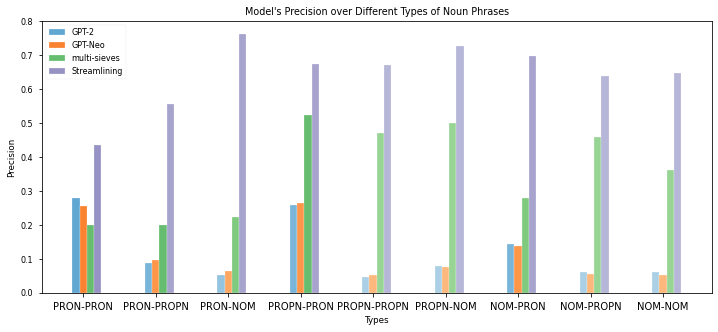

In [71]:
poses_scores_list, lengths_list = [], []
for df in dfs:
    poses_scores, lengths = get_pos_scores(df)
    poses_scores_list.append(poses_scores)
    lengths_list.append(lengths)

# colors_list = [Blues9, Reds9, Blues9, Reds9,]
# 'Blues','Oranges','Greens', 'Purples','Reds'

create_stacked_bar_plot(poses_scores_list, lengths_list, labels,
                        (12,5), "precision", 
                        "Model's Precision over Different Types of Noun Phrases", 
                        "Types", "Precision")

### performance across different entity types 

In [72]:
named_entity_types=['TIME', 'EVENT', 'MONEY', 'PRODUCT', 'PERSON', 
                    'WORK_OF_ART', 'GPE', 'NORP', 'FAC', 'ORDINAL', 'ORG', 'CARDINAL', 'LOC', 'DATE']


In [73]:
def get_entity_type_score(df):
    entity_scores_map = {"acc": [],
                     "precision": [],
                     "recall": [],
                     "f1": [],
                     "auc": []}
    lengths_map = []

    for m1_entity_type in named_entity_types:
        m1_mask = df["m1 entity types"].apply(lambda x: m1_entity_type in x)
        m1_entity_scores = {"acc": [],
                            "precision": [],
                            "recall": [],
                            "f1": [],
                            "auc": []}

        lengths = []
        for m2_entity_type in named_entity_types:
            m2_mask = df["m2 entity types"].apply(lambda x: m2_entity_type in x)
            subset = df[m1_mask | m2_mask]
            try:
                lengths.append(len(subset))
                scores = get_metrics_scores(subset, METRICS, "mean")
                for metric in m1_entity_scores:
                    m1_entity_scores[metric].append(scores[metric])
            except:
                lengths.append(len(subset))
                for metric in m1_entity_scores:
                    m1_entity_scores[metric].append(np.nan)
                print("No enought data for %s, only %s rows"%(m2_entity_type, len(subset)))
    
        lengths_map.append(lengths)
        for metric in entity_scores_map:
            entity_scores_map[metric].append(m1_entity_scores[metric])

    return entity_scores_map, lengths_map


In [74]:
def entity_type_heatmap(model, metric, entity_scores_map, lengths_map, named_entity_types, dir_path=results_path):
    if metric == "acc":
        label = "Accuracy"
    elif metric == "auc":
        label = "AUC"
    else:
        label = metric.capitalize()
    fig, ax = plt.subplots(figsize=(20,12))
    orig_cmap = plt.cm.Blues #OrRd", PuBu, YlGn
    colors = orig_cmap(np.linspace(0.1, 1, 10))
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colors)

    im, cbar = heatmap(np.array(entity_scores_map[metric]), list(named_entity_types), list(named_entity_types), ax=ax,
                   cmap=cmap, cbarlabel=label, vmin=0, vmax=1) 
    texts = annotate_heatmap(im, valfmt="{x:.0f}", lengths_map = lengths_map)
    # plt.title(f"{label} - ({model})")
    # scores for mentions with different entity types
    fig.tight_layout()
    path = os.path.join(results_path,f"{model}_{label}_entity_type_heatmap.png")
    fig.savefig(path, dpi = 100,bbox_inches = 'tight')
    print(f"Image saved to {path}")


No enought data for EVENT, only 41 rows
No enought data for MONEY, only 35 rows
('black', 'white')
Image saved to /content/drive/MyDrive/Coref-for-GPT/Results/Charts_and_plots/final_plots/GPT2_gold_mentions_Precision_entity_type_heatmap.png
No enought data for EVENT, only 41 rows
No enought data for MONEY, only 35 rows
('black', 'white')
Image saved to /content/drive/MyDrive/Coref-for-GPT/Results/Charts_and_plots/final_plots/GPT_NEO-125M_gold_mentions_Precision_entity_type_heatmap.png
No enought data for EVENT, only 1 rows
No enought data for MONEY, only 0 rows
No enought data for WORK_OF_ART, only 27 rows
No enought data for EVENT, only 13 rows
No enought data for MONEY, only 12 rows
No enought data for WORK_OF_ART, only 39 rows
('black', 'white')
Image saved to /content/drive/MyDrive/Coref-for-GPT/Results/Charts_and_plots/final_plots/multi-sieves_Precision_entity_type_heatmap.png
No enought data for MONEY, only 42 rows
No enought data for WORK_OF_ART, only 43 rows
No enought data for

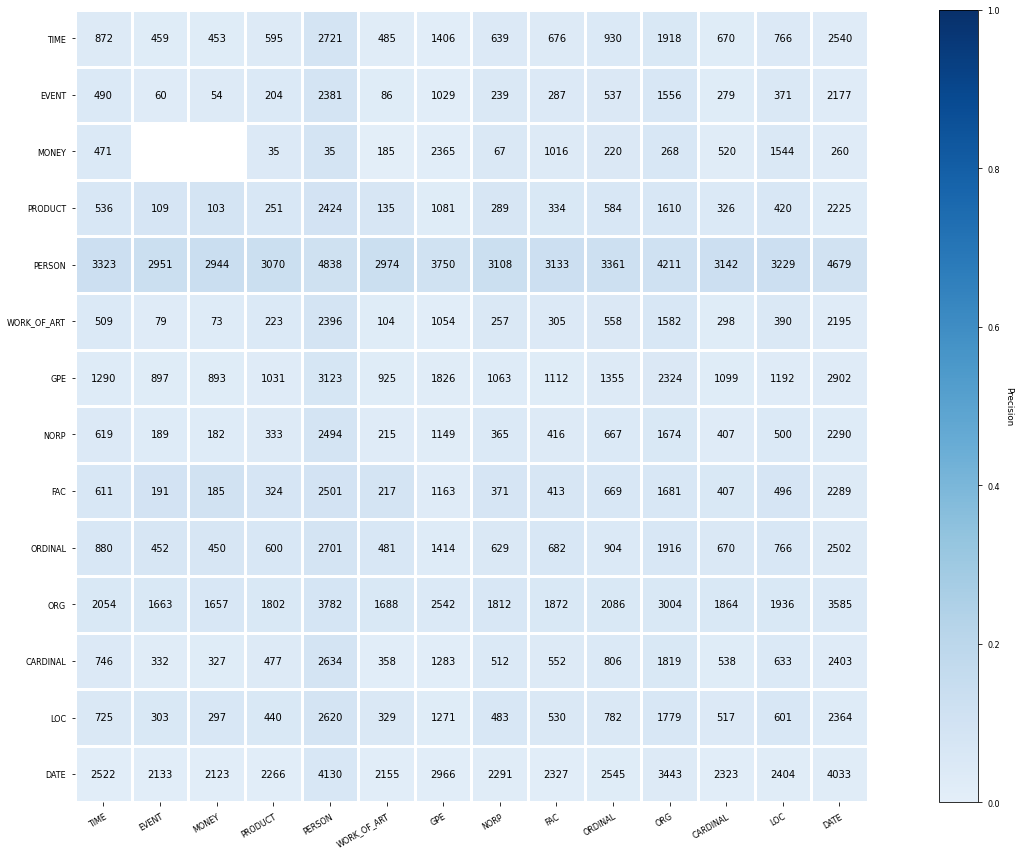

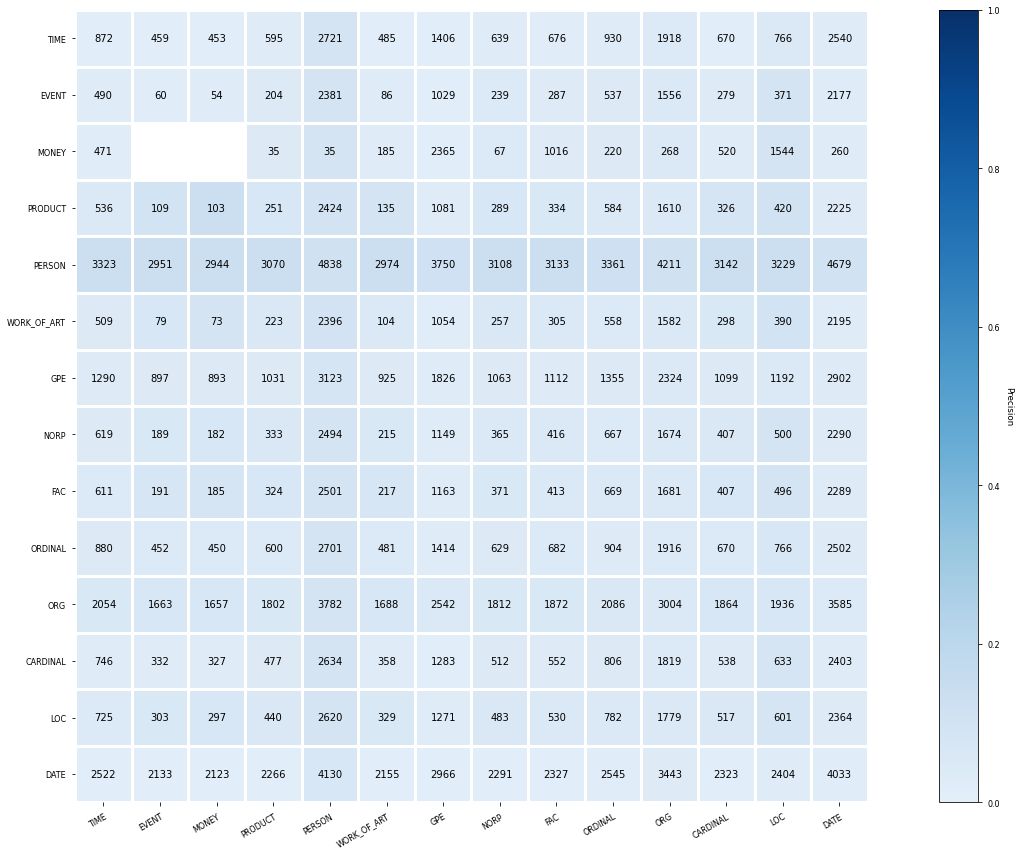

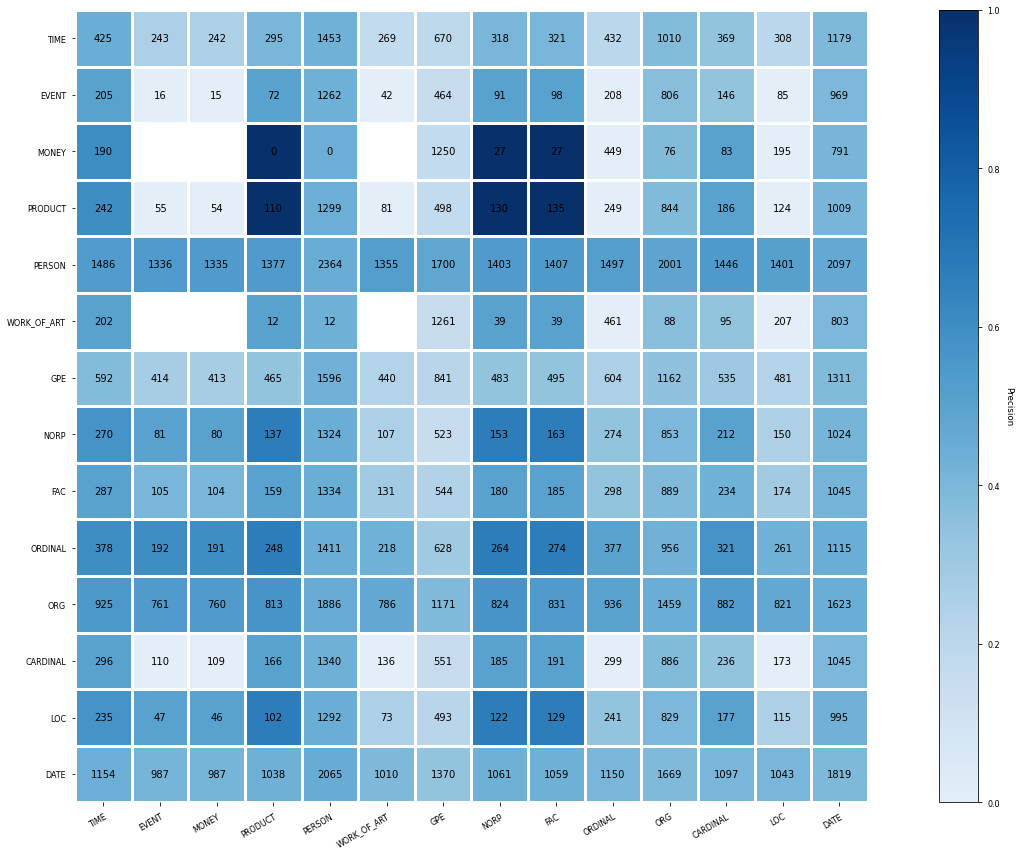

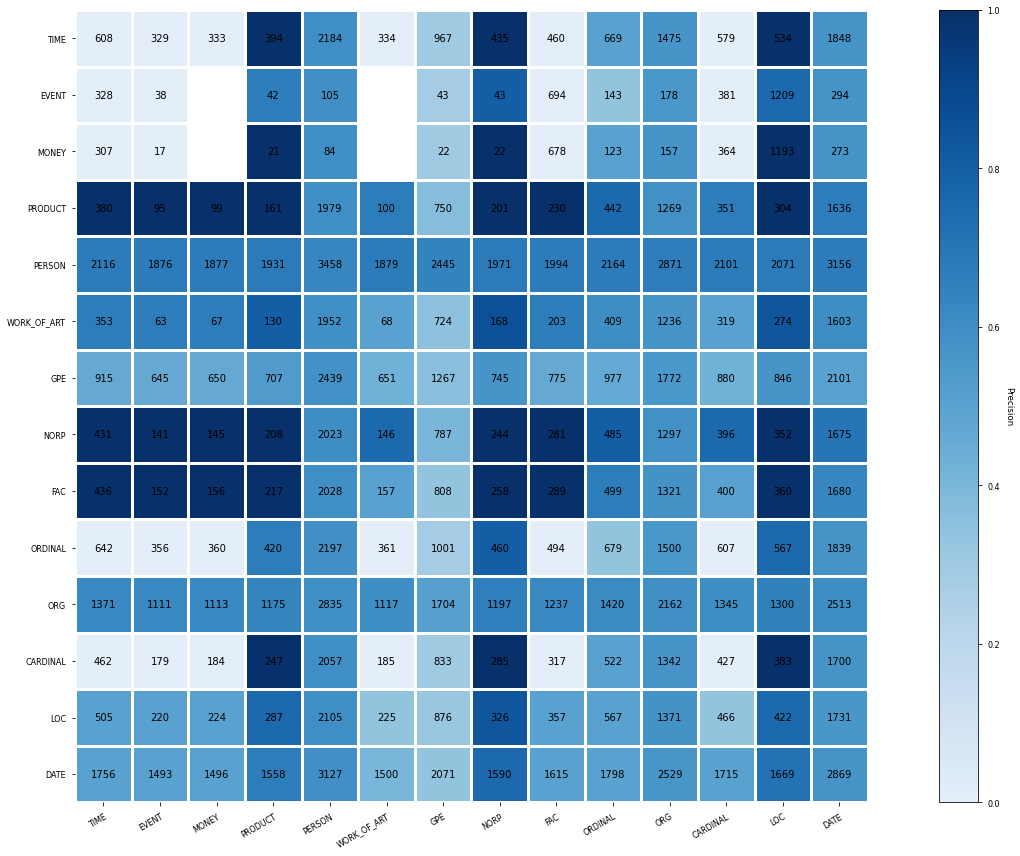

In [76]:
models = ["GPT2_gold_mentions", "GPT_NEO-125M_gold_mentions", "multi-sieves", "e2e", ] # "Streamlining", 

for i, df in enumerate(dfs):
    model = models[i]
    entity_scores_map, lengths_map = get_entity_type_score(df)
    entity_type_heatmap(model, "precision", entity_scores_map, lengths_map,
                    named_entity_types, dir_path=results_path)

### prediction accuracy for mention pairs with different similarity level

In [ ]:
def get_mention_similarity_based_scores(model_name, n_shot=4, prefix_type="ecb",
                                        similarity_type="fuzzy", metrics=METRICS, aggregate_type="mean"):
    if model_name in ["multi-sieves", "e2e", "Streamlining"]:
        mention_info = process_mention_info_nonGPT(model_name, parse_entity_type=False,
                                                   mention_similarity_type=similarity_type)
        
        pred_info = process_prediction_results_nonGPT(model_name)

    else:
        mention_info = process_mention_info(model_name, n_shot, prefix_type, parse_entity_type=False,
                                            mention_similarity_type=similarity_type)
        pred_info = process_prediction_results(model_name, n_shot, prefix_type)

    df = pd.concat([pred_info.drop(columns="label"), mention_info], axis=1)
    similarities = [(5+i*10, 5+(i+1)*10) for i in range(-1,10)]
    sim_scores = {}
    datas = []
    for i, sim_range in enumerate(similarities):
        data = df[((df['mention similarity']>=sim_range[0]) & (df['mention similarity']<sim_range[1]))]
        try:
            scores = get_metrics_scores(data, metrics, aggregate_type)
            datas.append(data)

            range_id = f"{int(sum(sim_range)/2)}%"
            sim_scores[range_id] = scores
        except:
            print(f"{sim_range} doesn't have enough data.")
            continue
    sim_scores = pd.DataFrame(sim_scores).T
    return sim_scores, datas

In [ ]:
models = ["GPT2_gold_mentions", "GPT_NEO-125M_gold_mentions", "multi-sieves", "Streamlining", "e2e",]

scores_list = []
datas_list = []
for model in tqdm(models):
    scores, datas = get_mention_similarity_based_scores(model,
                                                        similarity_type="fuzzy",
                                                        aggregate_type="mean")
    scores_list.append(scores)
    datas_list.append(datas)

  0%|          | 0/5 [00:00<?, ?it/s]

path: /content/drive/MyDrive/Coref-for-GPT/Results/GPT2/GPT2_gold_mentions_4-shots_ecb_prefix_5-repeats.csv


  0%|          | 0/17832 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:07<00:28,  7.12s/it]

path: /content/drive/MyDrive/Coref-for-GPT/Results/GPT-NEO/GPT_NEO-125M_gold_mentions_4-shots_ecb_prefix_5-repeats.csv


  0%|          | 0/17832 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:13<00:20,  6.91s/it]

  0%|          | 0/7978 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:15<00:08,  4.40s/it]

  0%|          | 0/4263 [00:00<?, ?it/s]

 80%|████████  | 4/5 [00:15<00:02,  2.81s/it]

  0%|          | 0/12550 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:17<00:00,  3.59s/it]


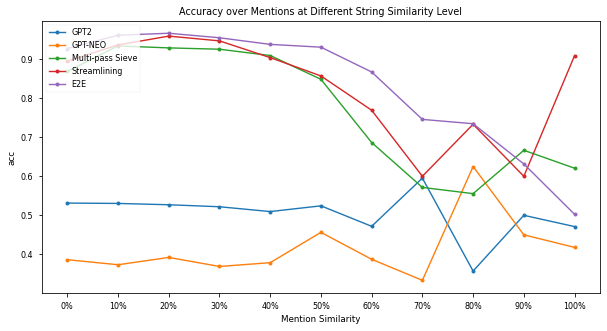

In [ ]:
metric = "acc"
model_labels = [MODEL_LABELS[m] for m in models]
fig = create_line_plot(scores_list, model_labels, metric,
                 "Accuracy over Mentions at Different String Similarity Level", 
                 "Mention Similarity", metric, (10,5))

In [ ]:
models = ["GPT2_gold_mentions", "GPT_NEO-125M_gold_mentions", "multi-sieves", "Streamlining","e2e",] 

embed_scores_list = []
embed_datas_list = []
for model in tqdm(models):
    scores, datas = get_mention_similarity_based_scores(model,
                                                        similarity_type="word2vec",
                                                        aggregate_type="mean")
    
    embed_scores_list.append(scores)
    embed_datas_list.append(datas)

  0%|          | 0/5 [00:00<?, ?it/s]

path: /content/drive/MyDrive/Coref-for-GPT/Results/GPT2/GPT2_gold_mentions_4-shots_ecb_prefix_5-repeats.csv


  0%|          | 0/17832 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:16<01:07, 16.97s/it]

path: /content/drive/MyDrive/Coref-for-GPT/Results/GPT-NEO/GPT_NEO-125M_gold_mentions_4-shots_ecb_prefix_5-repeats.csv


  0%|          | 0/17832 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:30<00:44, 14.99s/it]

  0%|          | 0/7978 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:35<00:20, 10.32s/it]

  0%|          | 0/4263 [00:00<?, ?it/s]

 80%|████████  | 4/5 [00:37<00:07,  7.06s/it]

  0%|          | 0/12550 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:44<00:00,  8.92s/it]


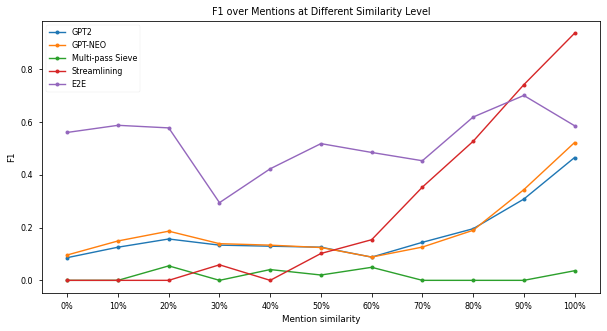

In [ ]:
metric = "f1"
model_labels = [MODEL_LABELS[m] for m in models]
fig = create_line_plot(embed_scores_list, model_labels, metric, 
                 "F1 over Mentions at Different Similarity Level", 
                 "Mention Similarity", metric, (10,5))